In [1]:
import os
from pathlib import Path
import pandas as pd
import torch
from datasets import Dataset
from torch.utils.data import Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np
import csv
import re
import spacy
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import ast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch import nn
from transformers import BertTokenizerFast, BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments, PreTrainedTokenizerFast, EvalPrediction, DataCollatorWithPadding, BertForSequenceClassification
import transformers
import matplotlib.pyplot as plt
import torch.nn.functional as F

C:\Users\Anwender\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### To-do: Change path_to_folder to the path directing to the folder "Code" !

In [2]:
# TODO: Change this to the path to the folder "Code"!
path_to_folder = "C:\\Users\\Anwender\\Desktop\\" 

### Read all csv files and load the trained models (Classifier A and B)

In [3]:
# read and store all csv files
unlabeled_data = path_to_folder + "Code\\Test_Set\\testSetData.csv"
train_data = path_to_folder + "Code\\Test_Set\\trainData.csv"
valid_data = path_to_folder + "Code\\Test_Set\\validData.csv"

unlabeled_df = pd.read_csv(unlabeled_data)
train_df = pd.read_csv(train_data)
valid_df = pd.read_csv(valid_data)

# after reading csv files the strings need to be converted into lists again
def convert_string_to_list(df, column_names):
    for column_name in column_names:
        if df[column_name].apply(lambda x: isinstance(x, str)).all():
            df[column_name] = df[column_name].apply(ast.literal_eval)
    return df

data_frames = [
    (unlabeled_df, ['BIO_tags', 'Animated_NP',
                     'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token']),
    (train_df, ['BIO_tags', 'Animated_NP',
                     'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token']),
    (valid_df, ['BIO_tags', 'Animated_NP', 'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token']),
]

for df, column_names in data_frames:
    convert_string_to_list(df, column_names)

In [4]:
nlp = spacy.load("de_core_news_lg")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "bert-base-german-cased"
tokenizer_B = BertTokenizer.from_pretrained(model_name)
tokenizer_A = BertTokenizerFast.from_pretrained(model_name)

In [5]:
def reset_columns(data):
    data['Animated_NP'] = [[]] * len(data)
    data['Animated_Prob_NP'] = [[]] * len(data)
    data['Animated_Token'] = [[]] * len(data)
    data['Animated_Prob_Token'] = [[]] * len(data)

reset_columns(unlabeled_df)

In [6]:
# load the trained BERT model with sequence classification (classifier B)
trained_model_B = BertForSequenceClassification.from_pretrained(path_to_folder + "Code\\ClassifierB\\BERT_Model\\")

In [7]:
# predictions for test set made by classifier B
def predict_animation_status_and_probs_B(unlabeled_df, model, tokenizer: PreTrainedTokenizerFast):

    def extract_phrases(tagged_sentence):
        return re.findall(r'\[START\](.*?)\[END\]', tagged_sentence)
    
    def tokenize_phrases(phrases):
        if not phrases:
            return None
        return tokenizer(phrases, truncation=True, padding=True, max_length=512, return_tensors="pt")

    def predict_with_model(tokenized_phrases, model):
        device = next(model.parameters()).device
        tokenized_phrases = {k: v.to(device) for k, v in tokenized_phrases.items()}
        with torch.no_grad():
            outputs = model(**tokenized_phrases)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
            return (np.max(probs, axis=-1)).tolist(), np.argmax(probs, axis=-1).tolist()

    def create_animated_tokens(row):
        tagged_sentence = row['Tagged_Sentence']
        animated_np = row['Animated_NP']
        tokens = tagged_sentence.split()
        animated_tokens = []
        inside_animated_phrase = False
        animated_np_index = 0
        for token in tokens:
            if token == '[START]':
                inside_animated_phrase = animated_np[animated_np_index] == 1
                continue
            elif token == '[END]':
                inside_animated_phrase = False
                animated_np_index += 1
                continue
            animated_tokens.append(1 if inside_animated_phrase else 0)
        return animated_tokens

    def create_animated_tokens_and_probs(row):
        bio_tags = row['BIO_tags']
        animated_np_probs = row['Animated_Prob_NP']
        animated_prob_token = []
        np_counter = 0
        for tag in bio_tags:
            if tag == "B":
                if np_counter < len(animated_np_probs):
                    current_prob = animated_np_probs[np_counter]
                    np_counter += 1
                else:
                    current_prob = 0
                animated_prob_token.append(current_prob)
            elif tag == "I":
                animated_prob_token.append(current_prob)
            else:
                animated_prob_token.append(0.99)
        return animated_prob_token
    
    predictions_df = unlabeled_df.copy()

    for index, row in predictions_df.iterrows():
        phrases = extract_phrases(row['Tagged_Sentence'])
        tokenized_phrases = tokenize_phrases(phrases)

        if tokenized_phrases is not None and '[START]' in row['Tagged_Sentence']:
            confidences, predictions = predict_with_model(tokenized_phrases, model)
            predictions_df.at[index, 'Animated_NP'] = predictions
        else:
            predictions_df.at[index, 'Animated_NP'] = []
    

    predictions_df['Animated_Token'] = predictions_df.apply(create_animated_tokens, axis=1)

    return predictions_df

# assigns the predictions
unlabeled_df_B_pred = predict_animation_status_and_probs_B(unlabeled_df, trained_model_B, tokenizer_B)

# deletes unneccessary columns for simplicity
del unlabeled_df_B_pred["Unnamed: 0"]
del unlabeled_df_B_pred["Animated_False_Token"]
del unlabeled_df_B_pred["Animated_Prob_Token"]
del unlabeled_df_B_pred["Animated_True_Token"]
del unlabeled_df_B_pred["Animated_Prob_NP"]
del unlabeled_df_B_pred["Animated_Token"]

unlabeled_df_B_pred

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP
0,Das Angebot möblierter Wohnungen hat stark zug...,[START] Das Angebot [END] [START] möblierter W...,"[B, I, B, I, O, O, O]","[0, 0]"
1,Diese können unter bestimmten Voraussetzungen ...,[START] Diese [END] können unter [START] besti...,"[B, O, O, B, I, O, O, O, O]","[0, 0]"
2,Gegen diesen Trend will die SPD nun mit streng...,Gegen [START] diesen Trend [END] will [START] ...,"[O, B, I, O, B, I, O, O, B, I, O]","[0, 1, 0]"
3,Die Ampelkoalition steht derzeit für eines e...,[START] Die Ampelkoalition [END] steht derzeit...,"[B, I, O, O, O, B, O, O, O, B]","[1, 0, 0]"
4,Dabei bekommen die drei Regierungspartner viel...,Dabei bekommen [START] die drei Regierungspart...,"[O, O, B, I, I, B, I, O, O, O, O]","[1, 0]"
...,...,...,...,...
64,Das Bundeskabinett hat den Entwurf für den Hau...,[START] Das Bundeskabinett [END] hat [START] d...,"[B, I, O, B, I, O, B, I, O, O]","[1, 0, 0]"
65,Er enthält einige dicke Brocken espart ird ...,[START] Er [END] enthält [START] einige dicke ...,"[B, O, B, I, I, O, O, O, O, O]","[0, 0]"
66,Wofür die Ampel Geld ausgeben will - und wo si...,Wofür [START] die Ampel [END] [START] Geld [EN...,"[O, B, I, B, O, O, O, O, O, B, O, O]","[0, 0, 0]"
67,Die Ampelfraktionen haben weitere Details zum ...,[START] Die Ampelfraktionen [END] haben [START...,"[B, I, O, B, I, O, B, O]","[0, 0, 0]"


In [8]:
# load the trained BERT model with sequence classification (classifier B)
model_path = "Code\\ClassifierA\\BERT_Model\\bert-base-german-token-classification"

trained_model_A = BertForTokenClassification.from_pretrained('bert-base-german-cased')
trained_model_A.load_state_dict(torch.load(path_to_folder + model_path))

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-b

<All keys matched successfully>

In [9]:
trained_model_A

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [10]:
trained_model_B

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
# predictions for test set made by classifier A

def predict_animation_status_and_probs_A(unlabeled_df, model, tokenizer, device):
   
    # predict the classes for all tokens
    def predict_and_label(unlabeled_df, model, tokenizer, device):
        sentences = unlabeled_df["Sentence"].tolist()
        tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=False, return_tensors="pt", padding=True)
        
        tokenized_inputs_tensors = {k: v.to(device) for k, v in tokenized_inputs.items()}
        
        model.eval()
        with torch.no_grad():
            outputs = model(**tokenized_inputs_tensors)
        
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()
        
        label_map = {0: 0, 1: 1}
        sentence_level_predictions = []
        sentence_level_probabilities = []
        for i, (prediction, probability) in enumerate(zip(predictions, probabilities)):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            labels = []
            probs = []
            for word_idx, (label_id, prob) in zip(word_ids, zip(prediction, probability)):
                if word_idx is None:
                    continue
                elif word_idx != previous_word_idx:
                    labels.append(label_map[label_id])
                    probs.append(round(prob[label_id].item(), 2))
                previous_word_idx = word_idx
            sentence_level_predictions.append(labels)
            sentence_level_probabilities.append(probs)
        
        unlabeled_df["Animated_Token"] = sentence_level_predictions
        
        return unlabeled_df
    
    def adjust_animacy_based_on_bio_tags(df):
        def modify_animacy(row):
            bio_tags = row['BIO_tags']
            animated_tokens = row['Animated_Token'].copy()
            
            if len(bio_tags) != len(animated_tokens):
                return animated_tokens
            
            for i in range(len(bio_tags)):
                if bio_tags[i] == 'O':
                    animated_tokens[i] = 0
            
            return animated_tokens
        
        df['Animated_Token'] = df.apply(lambda row: modify_animacy(row), axis=1)
        
        return df

    pred_labeled_df = predict_and_label(unlabeled_df, model.to(device), tokenizer, device)
    pred_labeled_df = adjust_animacy_based_on_bio_tags(pred_labeled_df)

    return pred_labeled_df

# assigns predictions
unlabeled_df_A_pred = predict_animation_status_and_probs_A(unlabeled_df, trained_model_A, tokenizer_A, device)

# deletes unneccessary columns for simplicity
del unlabeled_df_A_pred["Unnamed: 0"]
del unlabeled_df_A_pred["Animated_False_Token"]
del unlabeled_df_A_pred["Animated_Prob_Token"]
del unlabeled_df_A_pred["Animated_True_Token"]
del unlabeled_df_A_pred["Animated_Prob_NP"]
del unlabeled_df_A_pred["Animated_NP"]

unlabeled_df_A_pred

,Sentence,Tagged_Sentence,BIO_tags,Animated_Token
0,Das Angebot möblierter Wohnungen hat stark zug...,[START] Das Angebot [END] [START] möblierter W...,"[B, I, B, I, O, O, O]","[0, 0, 0, 0, 0, 0, 0]"
1,Diese können unter bestimmten Voraussetzungen ...,[START] Diese [END] können unter [START] besti...,"[B, O, O, B, I, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Gegen diesen Trend will die SPD nun mit streng...,Gegen [START] diesen Trend [END] will [START] ...,"[O, B, I, O, B, I, O, O, B, I, O]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]"
3,Die Ampelkoalition steht derzeit für eines e...,[START] Die Ampelkoalition [END] steht derzeit...,"[B, I, O, O, O, B, O, O, O, B]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Dabei bekommen die drei Regierungspartner viel...,Dabei bekommen [START] die drei Regierungspart...,"[O, O, B, I, I, B, I, O, O, O, O]","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
64,Das Bundeskabinett hat den Entwurf für den Hau...,[START] Das Bundeskabinett [END] hat [START] d...,"[B, I, O, B, I, O, B, I, O, O]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
65,Er enthält einige dicke Brocken espart ird ...,[START] Er [END] enthält [START] einige dicke ...,"[B, O, B, I, I, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
66,Wofür die Ampel Geld ausgeben will - und wo si...,Wofür [START] die Ampel [END] [START] Geld [EN...,"[O, B, I, B, O, O, O, O, O, B, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
67,Die Ampelfraktionen haben weitere Details zum ...,[START] Die Ampelfraktionen [END] haben [START...,"[B, I, O, B, I, O, B, O]","[0, 0, 0, 0, 0, 0, 0, 0]"


In [12]:
# load original manually labeled data 

original_data = (path_to_folder + "Code\\Test_Set\\testSetData.csv")
original_df = pd.read_csv(original_data)

def convert_string_to_list(df, column_names):
    for column_name in column_names:
        if df[column_name].apply(lambda x: isinstance(x, str)).all():
            df[column_name] = df[column_name].apply(ast.literal_eval)
    return df

data_frames = [
    (original_df, ['BIO_tags', 'Animated_NP',
                     'Animated_Prob_NP', 'Animated_Token', 'Animated_Prob_Token'])
]

for df, column_names in data_frames:
    convert_string_to_list(df, column_names)
    
del original_df["Unnamed: 0"]
del original_df["Animated_False_Token"]
del original_df["Animated_Prob_Token"]
del original_df["Animated_True_Token"]
del original_df["Animated_Prob_NP"]
original_df

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP,Animated_Token
0,Das Angebot möblierter Wohnungen hat stark zug...,[START] Das Angebot [END] [START] möblierter W...,"[B, I, B, I, O, O, O]","[0, 0]","[0, 0, 0, 0, 0, 0, 0]"
1,Diese können unter bestimmten Voraussetzungen ...,[START] Diese [END] können unter [START] besti...,"[B, O, O, B, I, O, O, O, O]","[0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Gegen diesen Trend will die SPD nun mit streng...,Gegen [START] diesen Trend [END] will [START] ...,"[O, B, I, O, B, I, O, O, B, I, O]","[0, 1, 0]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]"
3,Die Ampelkoalition steht derzeit für eines e...,[START] Die Ampelkoalition [END] steht derzeit...,"[B, I, O, O, O, B, O, O, O, B]","[1, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Dabei bekommen die drei Regierungspartner viel...,Dabei bekommen [START] die drei Regierungspart...,"[O, O, B, I, I, B, I, O, O, O, O]","[1, 0]","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...
64,Das Bundeskabinett hat den Entwurf für den Hau...,[START] Das Bundeskabinett [END] hat [START] d...,"[B, I, O, B, I, O, B, I, O, O]","[1, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
65,Er enthält einige dicke Brocken espart ird ...,[START] Er [END] enthält [START] einige dicke ...,"[B, O, B, I, I, O, O, O, O, O]","[0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
66,Wofür die Ampel Geld ausgeben will - und wo si...,Wofür [START] die Ampel [END] [START] Geld [EN...,"[O, B, I, B, O, O, O, O, O, B, O, O]","[0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
67,Die Ampelfraktionen haben weitere Details zum ...,[START] Die Ampelfraktionen [END] haben [START...,"[B, I, O, B, I, O, B, O]","[1, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"


In [13]:
# compare predicted labels of both classifiers to the actual labels 

def compare_classifiers(df_manual, df_A, df_B, column_A="Animated_Token", column_B="Animated_NP"):
    # ensures that the indexes are the same across dataframes for accurate comparison
    df_manual = df_manual.sort_index()
    df_A = df_A.sort_index()
    df_B = df_B.sort_index()

    A_accuracy = 0
    B_accuracy = 0

    for idx in df_manual.index:
        manual_A = df_manual.loc[idx, column_A]
        A = df_A.loc[idx, column_A]
        manual_B = df_manual.loc[idx, column_B]
        B = df_B.loc[idx, column_B]
        
        # pad shorter lists with -1
        if len(manual_A) > len(A):
            A += [-1] * (len(manual_A) - len(A))
        elif len(A) > len(manual_A):
            manual_A += [-1] * (len(A) - len(manual_A))
            
        if len(manual_B) > len(B):
            B += [-1] * (len(manual_B) - len(B))
        elif len(B) > len(manual_B):
            manual_B += [-1] * (len(B) - len(manual_B))
            
        # accuracy for each row (comparing list of integers)
        A_accuracy += accuracy_score(manual_A, A)
        B_accuracy += accuracy_score(manual_B, B)

    A_accuracy /= len(df_manual)
    B_accuracy /= len(df_manual)

    results = {
        "A": {"accuracy": A_accuracy},
        "B": {"accuracy": B_accuracy}
    }

    return results

results = compare_classifiers(original_df, unlabeled_df_A_pred, unlabeled_df_B_pred)

# accuracies for classifier A and B on the test set
print("Classifier A Accuracy: ", results["A"]["accuracy"])
print("Classifier B Accuracy: ", results["B"]["accuracy"])

Classifier A Accuracy:  0.921812176656222
Classifier B Accuracy:  0.9516908212560385


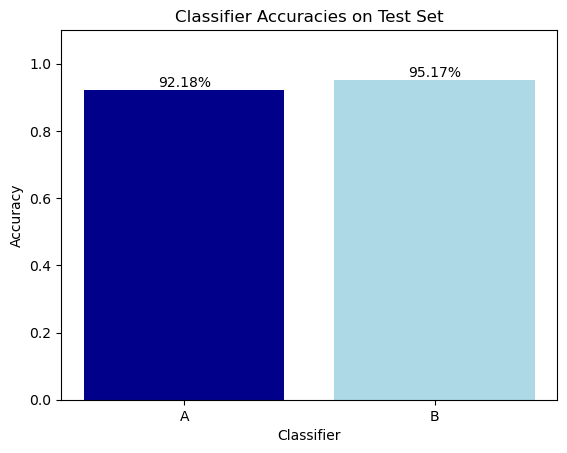

In [14]:
def plot_accuracy(results):
    # Create lists for the plot
    classifiers = ['A', 'B']
    accuracies = [results['A']['accuracy'], results['B']['accuracy']]

    # Create a bar chart
    bars = plt.bar(classifiers, accuracies, color=['darkblue', 'lightblue'])

    # Add a title and labels
    plt.title('Classifier Accuracies on Test Set')
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)

    # Adding percentages on top of each bar
    for bar, accuracy in zip(bars, accuracies):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{accuracy:.2%}', ha='center', va='bottom')

    # Show the plot
    plt.show()

# Call the function with the results
plot_accuracy(results)

In [15]:
# shows the predictions and the actual labels of the test set
original_df["Pred_A"] = unlabeled_df_A_pred["Animated_Token"]
original_df["Pred_B"] = unlabeled_df_B_pred["Animated_NP"]

original_df = original_df.reindex(columns=['Sentence', 'Tagged_Sentence', 'BIO_tags', 'Animated_Token', 'Pred_A', 'Animated_NP', 'Pred_B'])
pd.set_option('display.max_colwidth', None)
original_df

,Sentence,Tagged_Sentence,BIO_tags,Animated_Token,Pred_A,Animated_NP,Pred_B
0,Das Angebot möblierter Wohnungen hat stark zugenommen,[START] Das Angebot [END] [START] möblierter Wohnungen [END] hat stark zugenommen,"[B, I, B, I, O, O, O]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0]","[0, 0]"
1,Diese können unter bestimmten Voraussetzungen deutlich teurer vermietet werden,[START] Diese [END] können unter [START] bestimmten Voraussetzungen [END] deutlich teurer vermietet werden,"[B, O, O, B, I, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0]","[0, 0]"
2,Gegen diesen Trend will die SPD nun mit strengeren Regeln vorgehen,Gegen [START] diesen Trend [END] will [START] die SPD [END] nun mit [START] strengeren Regeln [END] vorgehen,"[O, B, I, O, B, I, O, O, B, I, O]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]","[0, 1, 0]","[0, 1, 0]"
3,Die Ampelkoalition steht derzeit für eines ede enge treit.,[START] Die Ampelkoalition [END] steht derzeit für [START] eines [END] ede enge [START] treit. [END],"[B, I, O, O, O, B, O, O, O, B]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]","[1, 0, 0]"
4,Dabei bekommen die drei Regierungspartner viele Gesetze auch ziemlich geräuschlos hin,Dabei bekommen [START] die drei Regierungspartner [END] [START] viele Gesetze [END] auch ziemlich geräuschlos hin,"[O, O, B, I, I, B, I, O, O, O, O]","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[1, 0]","[1, 0]"
...,...,...,...,...,...,...,...
64,Das Bundeskabinett hat den Entwurf für den Haushalt 2024 beschlossen,[START] Das Bundeskabinett [END] hat [START] den Entwurf [END] für [START] den Haushalt [END] 2024 beschlossen,"[B, I, O, B, I, O, B, I, O, O]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]","[1, 0, 0]"
65,Er enthält einige dicke Brocken espart ird ber rotzdem.,[START] Er [END] enthält [START] einige dicke Brocken [END] espart ird ber rotzdem.,"[B, O, B, I, I, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0]","[0, 0]"
66,Wofür die Ampel Geld ausgeben will - und wo sie noch streitet,Wofür [START] die Ampel [END] [START] Geld [END] ausgeben will - und wo [START] sie [END] noch streitet,"[O, B, I, B, O, O, O, O, O, B, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
67,Die Ampelfraktionen haben weitere Details zum Heizungsgesetz ausgearbeitet,[START] Die Ampelfraktionen [END] haben [START] weitere Details [END] zum [START] Heizungsgesetz [END] ausgearbeitet,"[B, I, O, B, I, O, B, O]","[1, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]","[0, 0, 0]"
